In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Add, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from tensorflow.keras.applications.efficientnet import preprocess_input
import warnings
from tqdm import tqdm

In [2]:
dataset_path = '/kaggle/input/apple-disease-dataset/datasets'
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')

# List classes in the train directory
classes = os.listdir(train_path)
print(f"Classes: {classes}")

# Count images in each class (train)
for cls in classes:
    print(f"Train {cls}: {len(os.listdir(os.path.join(train_path, cls)))} images")

# Count images in each class (test)
for cls in classes:
    print(f"Test {cls}: {len(os.listdir(os.path.join(test_path, cls)))} images")


Classes: ['black_rot', 'healthy', 'cedar_apple_rust', 'apple_scab']
Train black_rot: 1987 images
Train healthy: 2008 images
Train cedar_apple_rust: 1760 images
Train apple_scab: 2016 images
Test black_rot: 497 images
Test healthy: 502 images
Test cedar_apple_rust: 440 images
Test apple_scab: 504 images


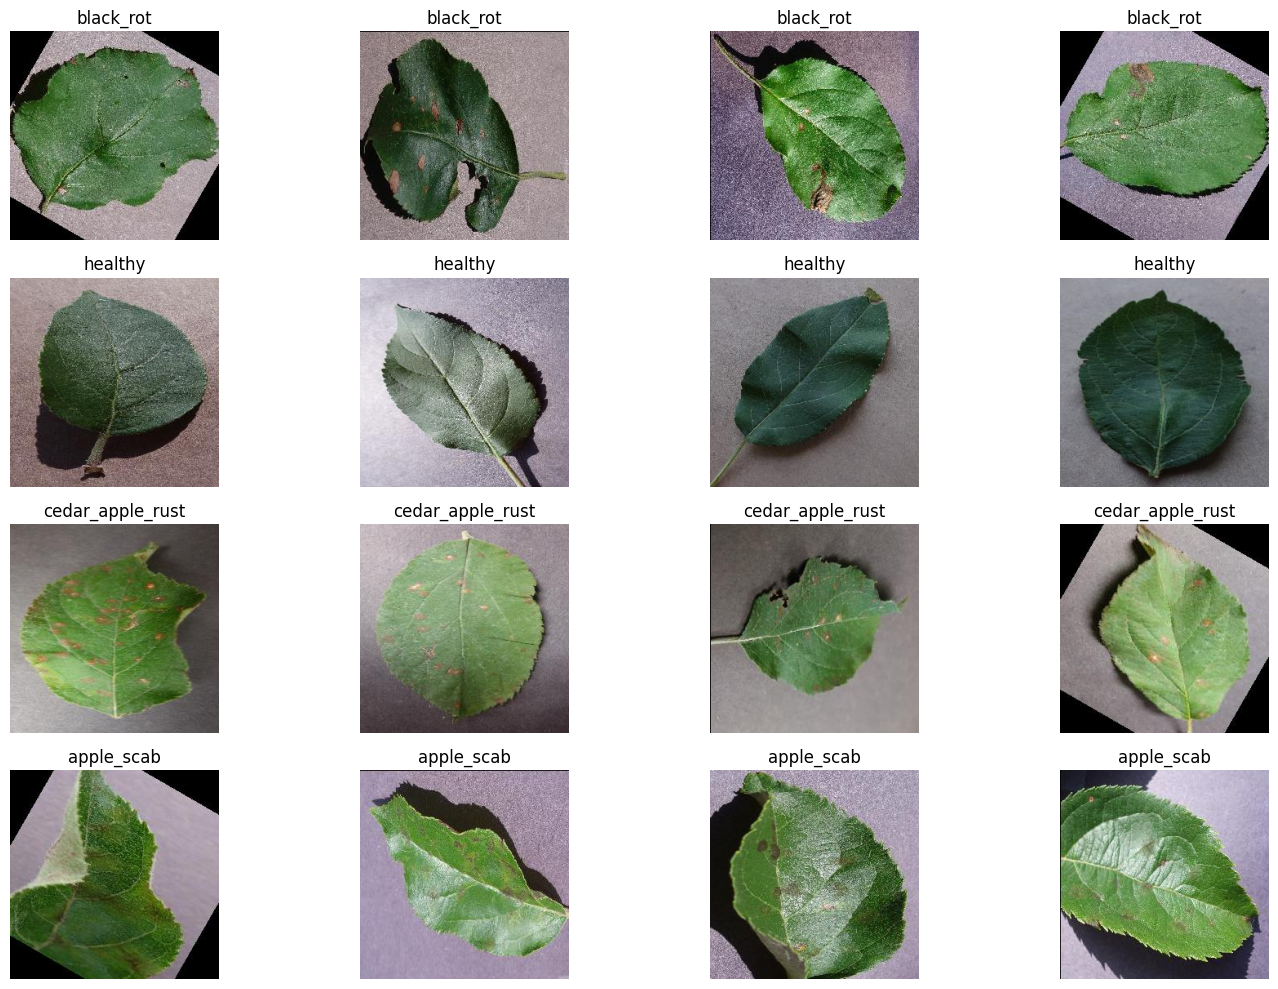

In [3]:
# Function to show sample images
def show_samples(path, num_samples=4):
    plt.figure(figsize=(15, 10))
    for i, cls in enumerate(classes):
        class_path = os.path.join(path, cls)
        images = os.listdir(class_path)[:num_samples]
        
        for j, img_name in enumerate(images):
            img = Image.open(os.path.join(class_path, img_name))
            plt.subplot(len(classes), num_samples, i*num_samples + j + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show train samples
show_samples(train_path)

Image dimensions summary:
       width  height
count   40.0    40.0
mean   256.0   256.0
std      0.0     0.0
min    256.0   256.0
25%    256.0   256.0
50%    256.0   256.0
75%    256.0   256.0
max    256.0   256.0


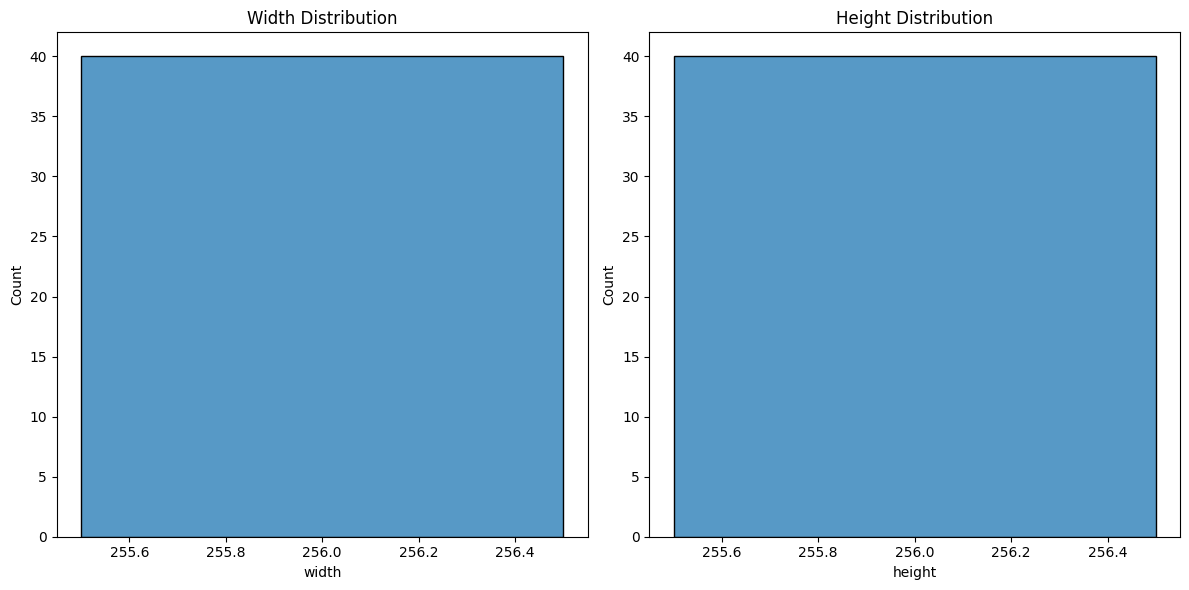

In [4]:
# Suppress all warnings 
warnings.filterwarnings('ignore')
# Check image dimensions
def check_dimensions(path):
    dimensions = []
    for cls in classes:
        class_path = os.path.join(path, cls)
        for img_name in os.listdir(class_path)[:10]:  # Check first 10 images
            img = Image.open(os.path.join(class_path, img_name))
            dimensions.append(img.size)
    
    return pd.DataFrame(dimensions, columns=['width', 'height'])

dim_df = check_dimensions(train_path)
print("Image dimensions summary:")
print(dim_df.describe())

# Plot dimensions distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(dim_df['width'])
plt.title('Width Distribution')
plt.subplot(1, 2, 2)
sns.histplot(dim_df['height'])
plt.title('Height Distribution')
plt.tight_layout()
plt.show()

In [5]:
augmented_dir = '/kaggle/working/augmented_dataset'
os.makedirs(augmented_dir, exist_ok=True)

# Classes from your dataset
classes = ['black_rot', 'healthy', 'cedar_apple_rust', 'apple_scab']

# Set image size for EfficientNetB0
IMG_SIZE = (224, 224)

# Data augmentation with EfficientNetB0 preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # EfficientNet-specific preprocessing
    shear_range=0.2,          # Random shear
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Random horizontal flip
    rotation_range=20,        # Add rotation for variety
    width_shift_range=0.2,    # Add width shift
    height_shift_range=0.2,   # Add height shift
    fill_mode='nearest',      # Fill empty pixels
    validation_split=0.2      # 20% for validation
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Function to augment each class to target count
def augment_to_target(source_dir, target_dir, target_count=2016):
    for cls in classes:
        src_cls_dir = os.path.join(source_dir, cls)
        aug_cls_dir = os.path.join(target_dir, cls)
        os.makedirs(aug_cls_dir, exist_ok=True)
        
        # Copy original images to augmented directory
        print(f"Copying original {cls} images...")
        for img_name in tqdm(os.listdir(src_cls_dir)):
            src_path = os.path.join(src_cls_dir, img_name)
            dst_path = os.path.join(aug_cls_dir, img_name)
            img = load_img(src_path, target_size=IMG_SIZE)  # Resize to IMG_SIZE
            save_img(dst_path, img_to_array(img))
        
        # Calculate how many more images are needed
        current_count = len(os.listdir(src_cls_dir))
        aug_needed = max(0, target_count - current_count)
        
        print(f"Augmenting {cls}: {current_count} -> {target_count} (+{aug_needed})")
        
        i = 0
        img_list = os.listdir(src_cls_dir)
        pbar = tqdm(total=aug_needed, desc=f"Generating augmented {cls} images")
        
        while i < aug_needed:
            img_name = img_list[i % len(img_list)]  # Cycle through original images
            img_path = os.path.join(src_cls_dir, img_name)
            
            try:
                img = load_img(img_path, target_size=IMG_SIZE)  # Resize to IMG_SIZE
                img_array = img_to_array(img)
                img_array = img_array.reshape((1,) + img_array.shape)  # Add batch dimension
                
                # Generate one augmented image
                for batch in train_datagen.flow(img_array, batch_size=1):
                    aug_img = batch[0]  # Already preprocessed by preprocess_input
                    save_img(os.path.join(aug_cls_dir, f'aug_{i}_{img_name}'), aug_img)
                    i += 1
                    pbar.update(1)
                    break  # One image per iteration
                    
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                i += 1  # Move to next image even if there's an error
        
        pbar.close()
        
        # Verify final count
        final_count = len(os.listdir(aug_cls_dir))
        print(f"Final count for {cls}: {final_count} images")

# Run the augmentation
print("Starting augmentation to reach 2016 images per class...")
augment_to_target(train_path, augmented_dir, target_count=2016)

# Function to create the data generator
def create_generator(directory, datagen, subset=None):
    return datagen.flow_from_directory(
        directory,
        target_size=IMG_SIZE,
        batch_size=32,
        class_mode='categorical',
        subset=subset,
        classes=classes  # Use the classes from your dataset
    )

# Create generators using the augmented dataset
train_generator = create_generator(augmented_dir, train_datagen, subset='training')
validation_generator = create_generator(augmented_dir, train_datagen, subset='validation')
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    classes=classes
)

# Verify generator outputs
print("\nVerifying data generators:")
print(f"Train samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

print("\nAugmentation complete!")
print("Augmented dataset saved to:", augmented_dir)

Starting augmentation to reach 2016 images per class...
Copying original black_rot images...


100%|██████████| 1987/1987 [00:19<00:00, 101.28it/s]


Augmenting black_rot: 1987 -> 2016 (+29)


Generating augmented black_rot images: 100%|██████████| 29/29 [00:00<00:00, 69.89it/s]


Final count for black_rot: 2016 images
Copying original healthy images...


100%|██████████| 2008/2008 [00:20<00:00, 99.23it/s] 


Augmenting healthy: 2008 -> 2016 (+8)


Generating augmented healthy images: 100%|██████████| 8/8 [00:00<00:00, 69.86it/s]


Final count for healthy: 2016 images
Copying original cedar_apple_rust images...


100%|██████████| 1760/1760 [00:16<00:00, 104.35it/s]


Augmenting cedar_apple_rust: 1760 -> 2016 (+256)


Generating augmented cedar_apple_rust images: 100%|██████████| 256/256 [00:03<00:00, 76.63it/s]


Final count for cedar_apple_rust: 2016 images
Copying original apple_scab images...


100%|██████████| 2016/2016 [00:20<00:00, 99.87it/s] 


Augmenting apple_scab: 2016 -> 2016 (+0)


Generating augmented apple_scab images: 0it [00:00, ?it/s]


Final count for apple_scab: 2016 images
Found 6452 images belonging to 4 classes.
Found 1612 images belonging to 4 classes.
Found 1943 images belonging to 4 classes.

Verifying data generators:
Train samples: 6452
Validation samples: 1612
Test samples: 1943

Augmentation complete!
Augmented dataset saved to: /kaggle/working/augmented_dataset


# **Custom cnn model**

In [6]:

def plot_training_history(history, model_name='Model'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



In [7]:
# Define the model with residual connections
inputs = Input(shape=(224, 224, 3))

# Convolutional Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Residual Block 1
residual = x
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Add()([x, residual])  # Residual connection
x = MaxPooling2D((2, 2))(x)

# Convolutional Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Residual Block 2
residual = Conv2D(128, (1, 1), padding='same')(x)  # Adjust channels for addition
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Add()([x, residual])
x = MaxPooling2D((2, 2))(x)

# Convolutional Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Global Average Pooling and Dense Layers
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)  # Reduced L2
x = Dropout(0.4)(x)  # Slightly reduced dropout
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
x = Dropout(0.4)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

# Create model
model_2 = Model(inputs, outputs)

# Optimizer with slightly higher initial learning rate
opt = Adam(learning_rate=0.0002, decay=1e-6)

# Compile the model
model_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1)  # Increased patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)  # More aggressive LR reduction

In [8]:
# Train the model
history = model_2.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_acc = model_2.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 121s 497ms/step - accuracy: 0.7059 - loss: 2.7442 - val_accuracy: 0.7847 - val_loss: 2.2147 - learning_rate: 2.0000e-04
Epoch 2/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 88s 423ms/step - accuracy: 0.9007 - loss: 1.8998 - val_accuracy: 0.9460 - val_loss: 1.5389 - learning_rate: 2.0000e-04
Epoch 3/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 89s 427ms/step - accuracy: 0.9433 - loss: 1.4926 - val_accuracy: 0.9280 - val_loss: 1.3345 - learning_rate: 2.0000e-04
Epoch 4/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 89s 427ms/step - accuracy: 0.9576 - loss: 1.2196 - val_accuracy: 0.9684 - val_loss: 1.0334 - learning_rate: 2.0000e-04
Epoch 5/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 91s 438ms/step - accuracy: 0.9644 - loss: 1.0006 - val_accuracy: 0.9777 - val_loss: 0.8342 - learning_rate: 2.0000e-04
Epoch 6/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 89s 426ms/step - accuracy: 0.9701 - loss: 0.8271 - val_accuracy: 0.9833 - val_loss: 0.6836 - learning_rate: 2.0000e-04
Epoch 7/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 88s 4

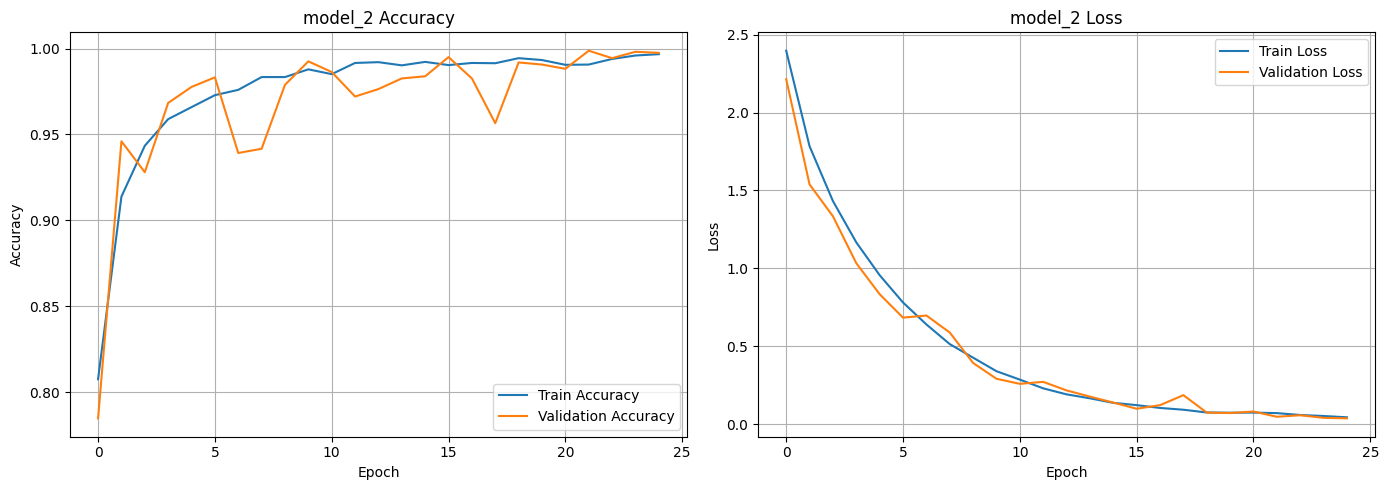

In [10]:
# Call the function
plot_training_history(history, model_name='model_2')

In [20]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load pre-trained EfficientNetB0 model with 224x224 input shape
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze most of the base model layers
for layer in base_model.layers[:-10]:  # Fine-tune only the last 10 layers
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
# Increased regularization and dropout
x = Dense(256, activation='relu', kernel_regularizer=l2(0.002))(x)
x = Dropout(0.5)(x)  # Increased dropout
x = Dense(128, activation='relu', kernel_regularizer=l2(0.002))(x)
x = Dropout(0.4)(x)  # Increased dropout
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the model
efficientnet_model = Model(inputs=base_model.input, outputs=predictions)

# Lower initial learning rate
opt = Adam(learning_rate=0.0001, decay=1e-6)
efficientnet_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Improved callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

# Train the model
historyefficient = efficientnet_model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 119s 480ms/step - accuracy: 0.5507 - loss: 2.2229 - val_accuracy: 0.9721 - val_loss: 1.3189 - learning_rate: 1.0000e-04
Epoch 2/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 82s 395ms/step - accuracy: 0.9337 - loss: 1.3428 - val_accuracy: 0.9808 - val_loss: 1.1171 - learning_rate: 1.0000e-04
Epoch 3/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 82s 393ms/step - accuracy: 0.9626 - loss: 1.1500 - val_accuracy: 0.9919 - val_loss: 1.0063 - learning_rate: 1.0000e-04
Epoch 4/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 82s 395ms/step - accuracy: 0.9762 - loss: 1.0271 - val_accuracy: 0.9913 - val_loss: 0.9162 - learning_rate: 1.0000e-04
Epoch 5/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 82s 396ms/step - accuracy: 0.9818 - loss: 0.9276 - val_accuracy: 0.9963 - val_loss: 0.8240 - learning_rate: 1.0000e-04
Epoch 6/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 82s 394ms/step - accuracy: 0.9910 - loss: 0.8257 - val_accuracy: 0.9944 - val_loss: 0.7424 - learning_rate: 1.0000e-04
Epoch 7/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 82s 3

In [21]:
# Evaluate the model on the test set
test_loss, test_acc = efficientnet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.9974 - loss: 0.0810
Test Accuracy: 0.9985


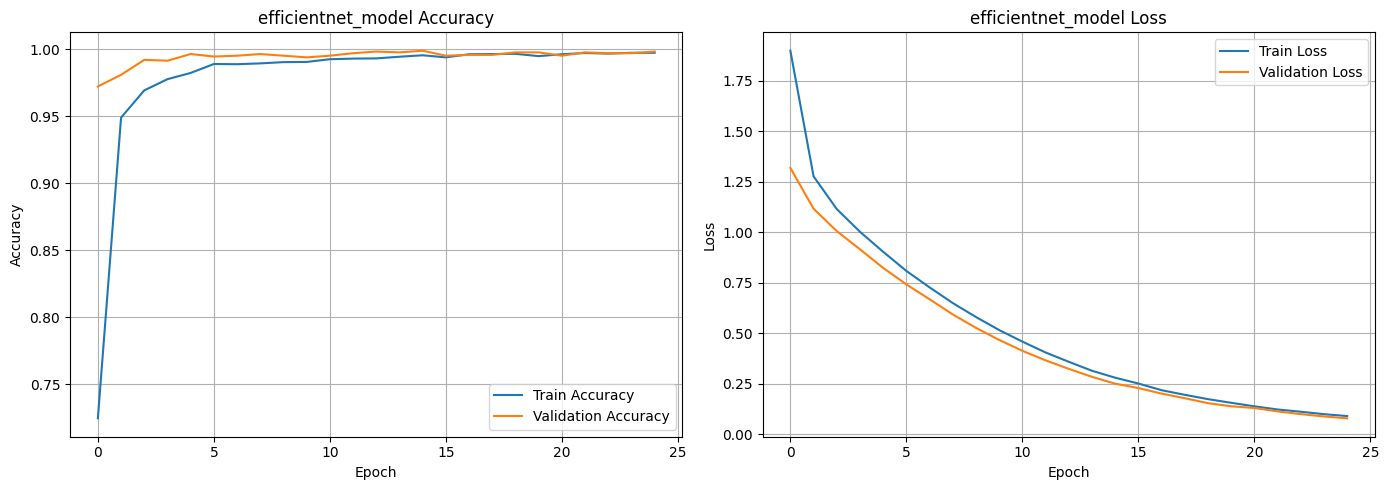

In [22]:
# Call the function
plot_training_history(historyefficient, model_name='efficientnet_model')

**VGG**

In [14]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load pre-trained VGG16 model (no top, with imagenet weights)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze most of the layers
for layer in base_model.layers[:-4]:  # Fine-tune only the last 4 layers
    layer.trainable = False

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.002))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.002))(x)
x = Dropout(0.4)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Combine base and custom layers
vgg_model = Model(inputs=base_model.input, outputs=predictions)

# Optimizer
opt = Adam(learning_rate=0.0001, decay=1e-6)
vgg_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

# Train the model
historyvgg = vgg_model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)


202/202 ━━━━━━━━━━━━━━━━━━━━ 140s 574ms/step - accuracy: 0.3529 - loss: 2.5937 - val_accuracy: 0.9032 - val_loss: 1.1817 - learning_rate: 1.0000e-04
Epoch 2/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 98s 473ms/step - accuracy: 0.9143 - loss: 1.1371 - val_accuracy: 0.9882 - val_loss: 0.8464 - learning_rate: 1.0000e-04
Epoch 3/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 95s 457ms/step - accuracy: 0.9733 - loss: 0.8782 - val_accuracy: 0.9653 - val_loss: 0.8338 - learning_rate: 1.0000e-04
Epoch 4/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 98s 473ms/step - accuracy: 0.9738 - loss: 0.7883 - val_accuracy: 0.9839 - val_loss: 0.7114 - learning_rate: 1.0000e-04
Epoch 5/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 97s 470ms/step - accuracy: 0.9907 - loss: 0.6757 - val_accuracy: 0.9876 - val_loss: 0.6451 - learning_rate: 1.0000e-04
Epoch 6/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 98s 468ms/step - accuracy: 0.9879 - loss: 0.6205 - val_accuracy: 0.9932 - val_loss: 0.5746 - learning_rate: 1.0000e-04
Epoch 7/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 98s 472ms/step -

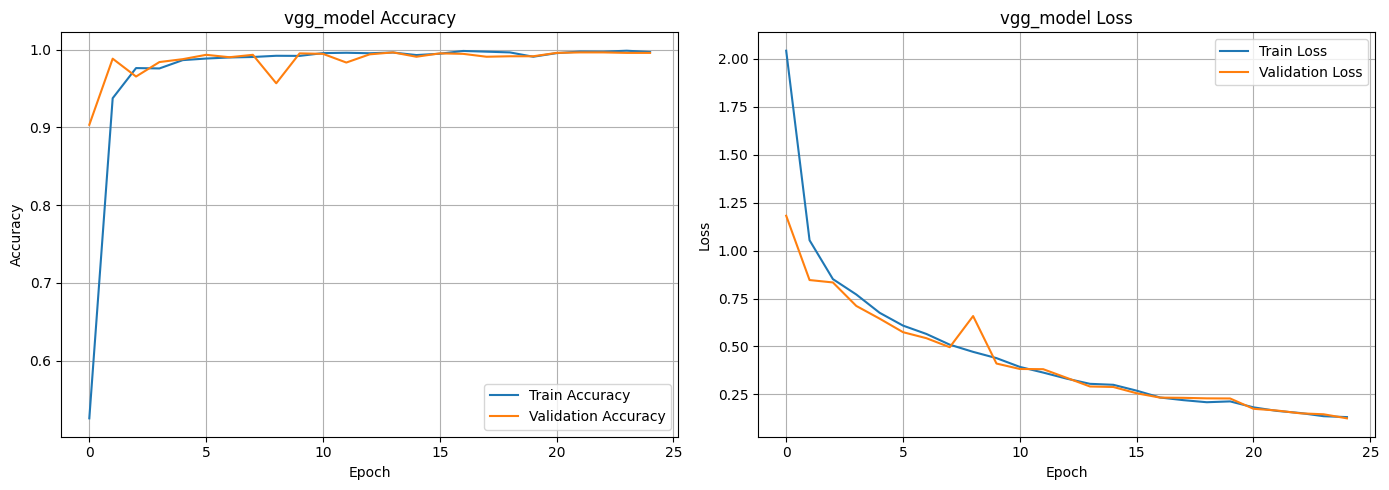

In [15]:
# Call the function
plot_training_history(historyvgg, model_name='vgg_model')